In [1]:
#import modules and read file into dataframe
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from openpyxl.workbook import Workbook

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

pd.options.display.max_columns=999
pd.options.display.max_rows=3000

data = pd.read_excel('Collections Case Study Data.xlsx', sheet_name=None)

## What is the account roll forward rate for the months of Mar , Apr, May and June for TB0?

In [109]:
#assign data to new dataframe and display keys
df = data
df.keys()

dict_keys(['Loan Details', 'Loan_Status_MartoMay', 'Loan_Status_AprtoJun', 'Historical 6 Months Details', 'Loan_ID mapping', 'Call Details'])

Assumptions made about data:
- 'Loan_Status_MartoMay' - gives data for loans that were TBO each month
- 'Loan_Status_AprtoJun' - gives data for the next month for loans that were TBO each month in 'Loan_Status_MartoMay'

In [110]:
#creates stratums for data based on month
mar_data = df['Loan_Status_MartoMay'].loc[df['Loan_Status_MartoMay']['Month'] == 'March']
apr_data = df['Loan_Status_MartoMay'].loc[df['Loan_Status_MartoMay']['Month'] == 'April']
may_data = df['Loan_Status_MartoMay'].loc[df['Loan_Status_MartoMay']['Month'] == 'May']
marapr_data = df['Loan_Status_AprtoJun'].loc[df['Loan_Status_AprtoJun']['Month'] == 'April']
aprmay_data = df['Loan_Status_AprtoJun'].loc[df['Loan_Status_AprtoJun']['Month'] == 'May']
mayjun_data = df['Loan_Status_AprtoJun'].loc[df['Loan_Status_AprtoJun']['Month'] == 'June']

In [112]:
#QC checking to see if our assumption is correct
print(len(mar_data) == len(marapr_data))
print(len(apr_data) == len(aprmay_data))
print(len(may_data) == len(mayjun_data))

True
True
True


In [113]:
#creates stratums for each month with performance in the following month
mar_data1 = pd.merge(mar_data, marapr_data, how='left', on='Loan_id', suffixes=('_mar', '_marapr'))
apr_data1 = pd.merge(apr_data, aprmay_data, how='left', on='Loan_id', suffixes=('_apr', '_aprmay'))
may_data1 = pd.merge(may_data, mayjun_data, how='left', on='Loan_id', suffixes=('_may', '_mayjun'))

In [114]:
#merges monthly data into one dataframe
data1 = pd.merge(mar_data1, apr_data1, how='outer', on='Loan_id')
data1 = pd.merge(data1, may_data1, how='outer', on='Loan_id')

In [115]:
#QC to ensure all data has been captured
len(data1) == len(df['Loan Details'])

True

In [116]:
#displays column names
data1.columns

Index(['Loan_id', 'Bucket_mar', 'TENURE_mar', 'PRINBALANCE_mar',
       'Months on Books_mar', 'Sanctioned Amount_mar', 'Month_mar',
       'Bucket_marapr', 'PRINBALANCE_marapr', 'TENURE_marapr',
       'Months on Books_marapr', 'Sanctioned Amount_marapr', 'Month_marapr',
       'Bucket_apr', 'TENURE_apr', 'PRINBALANCE_apr', 'Months on Books_apr',
       'Sanctioned Amount_apr', 'Month_apr', 'Bucket_aprmay',
       'PRINBALANCE_aprmay', 'TENURE_aprmay', 'Months on Books_aprmay',
       'Sanctioned Amount_aprmay', 'Month_aprmay', 'Bucket_may', 'TENURE_may',
       'PRINBALANCE_may', 'Months on Books_may', 'Sanctioned Amount_may',
       'Month_may', 'Bucket_mayjun', 'PRINBALANCE_mayjun', 'TENURE_mayjun',
       'Months on Books_mayjun', 'Sanctioned Amount_mayjun', 'Month_mayjun'],
      dtype='object')

In [117]:
#displays value counts for statuses in each month
cols = ['Bucket_mar','Bucket_marapr', 'Bucket_apr', 'Bucket_aprmay', 'Bucket_may', 'Bucket_mayjun']

for c in cols:
    print(c)
    print(data1[c].value_counts())
    print('\n')

Bucket_mar
TB0    24575
Name: Bucket_mar, dtype: int64


Bucket_marapr
REGULAR    22475
TB0         1709
TB1          391
Name: Bucket_marapr, dtype: int64


Bucket_apr
TB0    27079
Name: Bucket_apr, dtype: int64


Bucket_aprmay
REGULAR    24964
TB0         1574
TB1          541
Name: Bucket_aprmay, dtype: int64


Bucket_may
TB0    29115
Name: Bucket_may, dtype: int64


Bucket_mayjun
REGULAR    27085
TB0         1577
TB1          453
Name: Bucket_mayjun, dtype: int64




In [123]:
#creates a dataframe to display bucket migration for each month
cols1 = ['Bucket_mar', 'Bucket_apr', 'Bucket_may']
tot_TBO = pd.DataFrame()
for c in cols1:
    tot_TBO[c] = data1[c].value_counts()


cols2 = ['Bucket_marapr', 'Bucket_aprmay', 'Bucket_mayjun']
migration = pd.DataFrame()
for c in cols2:
    migration[c] = data1[c].value_counts()

print('Total TBO loans:')
print(tot_TBO)
print('\n')
print('Migration of loans after one month:')
print(migration)


Total TBO loans:
     Bucket_mar  Bucket_apr  Bucket_may
TB0       24575       27079       29115


Migration of loans after one month:
         Bucket_marapr  Bucket_aprmay  Bucket_mayjun
REGULAR          22475          24964          27085
TB0               1709           1574           1577
TB1                391            541            453


In [124]:
#calculates roll forward rate for each month
mar_roll = data1['Bucket_mar'].count() / len(data1) * 100
apr_roll = data1['Bucket_apr'].count() / len(data1) * 100
may_roll = data1['Bucket_may'].count() / len(data1) * 100

print('Roll rate for TBO loans in March: ', mar_roll)
print('Roll rate for TB0 loans in April: ', apr_roll)
print('Roll rate for TB0 loans in May:   ', may_roll)

Roll rate for TBO loans in March:  60.92119289025509
Roll rate for TB0 loans in April:  67.12858524009023
Roll rate for TB0 loans in May:    72.17581001016387


In [125]:
#QC checking to see whether there are more TBO loans in May than in March
len(may_data1) > len(mar_data1)

True

In [127]:
#calculates roll forward rate for loans after one month for loans that were TB0 each month
mar_roll1 = round(migration.iloc[2,0] / migration['Bucket_marapr'].sum() * 100, 3)
apr_roll1 = round(migration.iloc[2,1] / migration['Bucket_aprmay'].sum() * 100, 3)
may_roll1 = round(migration.iloc[2,2] / migration['Bucket_mayjun'].sum() * 100, 3)

print('Roll rate for March TB0 loans: ', mar_roll1)
print('Roll rate for April TB0 loans: ', apr_roll1)
print('Roll rate for May TB0 loans:   ', may_roll1)

Roll rate for March TB0 loans:  1.591
Roll rate for April TB0 loans:  1.998
Roll rate for May TB0 loans:    1.556


## What is the Princple outstanding balance roll forward rate for the same months as above for TB0?

Principal Balance was not provided for all loans for the beginning of March, therefore the rate was calculated against the total sanctioned amount of all loans.

In [130]:
#calculates total dollar santioned for entire portfolio
total_sanctioned = df['Loan Details']['Sanctioned Amount'].sum()

print('Total sanctioned amount: ', total_sanctioned)

Total sanctioned amount:  1862351670144


In [149]:
#calculates balance roll forward rate for each month
mar_bal_roll = data1['PRINBALANCE_mar'].sum() / total_sanctioned * 100
apr_bal_roll = data1['PRINBALANCE_apr'].sum() / total_sanctioned * 100
may_bal_roll = data1['PRINBALANCE_may'].sum() / total_sanctioned * 100

print('Balance roll rate for TB0 loans in March: ', mar_bal_roll)
print('Balance roll rate for TB0 loans in April: ', apr_bal_roll)
print('Balance roll rate for TB0 loans in May:   ', may_bal_roll)

Balance roll rate for TB0 loans in March:  44.44533007622233
Balance roll rate for TB0 loans in April:  48.56477897441339
Balance roll rate for TB0 loans in May:    53.393612868539655


## What is the average attempt intensity, RPC rate and PTP rate on accounts for the months of mar, Apr and May

In [150]:
df.keys()

dict_keys(['Loan Details', 'Loan_Status_MartoMay', 'Loan_Status_AprtoJun', 'Historical 6 Months Details', 'Loan_ID mapping', 'Call Details'])

In [151]:
#assigns 'Call Detail' table to dataframe
call_data = df['Call Details']
call_data.tail()

,month,Application_Id,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts
79609,5,MX-999897229,AGNT19,0,0,2
79610,5,MX-999911711,AGNT6,0,0,1
79611,5,MX-999978990,AGNT43,2,0,2
79612,5,MX-999980626,AGNT21,1,1,1
79613,5,MX-999985403,AGNT19,5,1,6


In [152]:
#groups call data by month and accounts and then aggregates
month_table = call_data.groupby(['month', 'Application_Id']).aggregate({'month':'nunique', 'Right_Party_Contact':'sum', 'Promise_to_pay':'sum', 'total_contacts':'sum'})

month_table.rename(columns={'month':'month_count'}, inplace=True)

month_table

month_count  Right_Party_Contact  Promise_to_pay  \
month Application_Id                                                     
3     MX-100062359              1                    1               1   
      MX-100095892              1                    1               0   
      MX-100116696              1                    2               0   
      MX-10011780               1                    2               1   
      MX-100133826              1                    4               3   
...                           ...                  ...             ...   
5     MX-999897229              1                    0               0   
      MX-999911711              1                    0               0   
      MX-999978990              1                    2               0   
      MX-999980626              1                    1               1   
      MX-999985403              1                    5               1   

                      total_contacts  
month Application_Id                  
3     MX-100062359                 1  
      MX-100095892                 2  
      MX-100116696                 3  
      MX-10011780                 10  
      MX-100133826                17  
...                              ...  
5     MX-999897229                 2  
      MX-999911711                 1  
      MX-999978990                 2  
      MX-999980626                 1  
      MX-999985403                 6  

[74925 rows x 4 columns]

In [153]:
#calculates Right Party Contacts (RPC) rate and Percentage of outbound calls resulting in Promise to Pay (PTP) for each account every month

month_table['RPC_rate'] = round(month_table['Right_Party_Contact'] / month_table['total_contacts'], 3)

month_table['PTP_rate'] = round(month_table['Promise_to_pay'] / month_table['total_contacts'], 3)

month_table

month_count  Right_Party_Contact  Promise_to_pay  \
month Application_Id                                                     
3     MX-100062359              1                    1               1   
      MX-100095892              1                    1               0   
      MX-100116696              1                    2               0   
      MX-10011780               1                    2               1   
      MX-100133826              1                    4               3   
...                           ...                  ...             ...   
5     MX-999897229              1                    0               0   
      MX-999911711              1                    0               0   
      MX-999978990              1                    2               0   
      MX-999980626              1                    1               1   
      MX-999985403              1                    5               1   

                      total_contacts  RPC_rate  PTP_rate  
month Application_Id                                      
3     MX-100062359                 1     1.000     1.000  
      MX-100095892                 2     0.500     0.000  
      MX-100116696                 3     0.667     0.000  
      MX-10011780                 10     0.200     0.100  
      MX-100133826                17     0.235     0.176  
...                              ...       ...       ...  
5     MX-999897229                 2     0.000     0.000  
      MX-999911711                 1     0.000     0.000  
      MX-999978990                 2     1.000     0.000  
      MX-999980626                 1     1.000     1.000  
      MX-999985403                 6     0.833     0.167  

[74925 rows x 6 columns]

In [154]:
#displays descriptive statistics for the grouped data

month_table.describe()

,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate
count,74925.0,74925.000000,74925.000000,74925.000000,74925.000000,74925.000000
mean,1.0,3.415028,1.189216,11.683096,0.491932,0.222600
std,0.0,6.855943,1.531626,21.936355,0.359137,0.302785
min,1.0,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,2.000000,0.198000,0.000000
50%,1.0,2.000000,1.000000,4.000000,0.429000,0.091000
75%,1.0,4.000000,2.000000,11.000000,1.000000,0.333000
max,1.0,651.000000,25.000000,659.000000,1.000000,1.000000


Due to the high max value for 'Right_Party_Contact' and 'total_contact', let's explore further

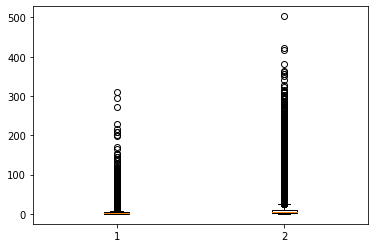

In [201]:
x = month_table['Right_Party_Contact']
y = month_table['total_contacts']

plt.boxplot([x,y])
plt.show()

In [163]:
#exploring max value observation further
month_table[month_table['Right_Party_Contact']==651]

,,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate
month,Application_Id,,,,,,
3,MX-641283899,1,651,2,659,0.988,0.003


The max value looks like an extreme outlier where there might have been an input error. I will exclude this case.

In [164]:
month_table = month_table[month_table['Right_Party_Contact']!=651]

In [165]:
month_table.describe()

,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate
count,74924.0,74924.000000,74924.000000,74924.000000,74924.000000,74924.000000
mean,1.0,3.406385,1.189205,11.674457,0.491926,0.222603
std,0.0,6.434843,1.531633,21.808653,0.359135,0.302786
min,1.0,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,2.000000,0.198000,0.000000
50%,1.0,2.000000,1.000000,4.000000,0.429000,0.091000
75%,1.0,4.000000,2.000000,11.000000,1.000000,0.333000
max,1.0,309.000000,25.000000,503.000000,1.000000,1.000000


There still seem to be high values but will need to research this further for correct treatment, so will leave this in for now.

In [166]:
#calculates average rates for each month based on account activity
avg_monthly = month_table.groupby('month').agg({'total_contacts':'mean', 'RPC_rate':'mean', 'PTP_rate':'mean'})

avg_monthly.rename(columns={'total_contacts':'avg_intensity','RPC_rate':'avg_rpc_rate', 'PTP_rate':'avg_ptp_rate'}, inplace=True)

avg_monthly

,avg_intensity,avg_rpc_rate,avg_ptp_rate
month,,,
3,12.957694,0.494614,0.236683
4,11.247509,0.484527,0.218108
5,10.963286,0.496549,0.214621


## Is there any correlation between the princple balance remaining and the term completed

In [194]:

bal_term_data = df['Loan_Status_MartoMay']

In [195]:
len(bal_term_data)

80769

In [196]:
bal_term_data.head()

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month
0,A810487695,TB0,48,10539100.0,37,30000000,April
1,A205346000,TB0,36,3693500.0,33,22000000,March
2,A675851816,TB0,48,24353700.0,30,40000000,March
3,A810487695,TB0,48,9649000.0,38,30000000,May
4,A269873383,TB0,36,4441700.0,30,20000000,May


In [197]:
bal_term_data = bal_term_data.drop_duplicates(subset='Loan_id', keep='first')

In [198]:
len(bal_term_data)

40339

In [199]:
#calculates term completed as defined by 'month on books/tenure'
bal_term_data['term_comp'] = bal_term_data['Months on Books'] / bal_term_data['TENURE']

bal_term_data.head()

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month,term_comp
0,A810487695,TB0,48,10539100.0,37,30000000,April,0.770833
1,A205346000,TB0,36,3693500.0,33,22000000,March,0.916667
2,A675851816,TB0,48,24353700.0,30,40000000,March,0.625000
4,A269873383,TB0,36,4441700.0,30,20000000,May,0.833333
5,A948976866,TB0,36,20002300.0,19,30000000,April,0.527778


In [200]:
var1 = bal_term_data['term_comp']
var2 = bal_term_data['PRINBALANCE']

correlation = var1.corr(var2)
correlation

-0.551402347382676

If we estimate the absolute correlation value as being moderate if it falls between 0.5 and 0.7, we can conclude that there is a moderate correlation between term completed and principal balance.  In addition as this is a negative value, we conclude that this is a negative relationship, meaning as there is an increase in one variable there is a decrease in the other and vice-versa.

## Identify the agents who are showing the best and worst performance. 

In [102]:
call_data.head()

,month,Application_Id,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts
0,3,MX-100062359,AGNT50,1,1,1
1,3,MX-100095892,AGNT12,1,0,2
2,3,MX-100116696,AGNT36,2,0,3
3,3,MX-10011780,AGNT39,2,1,10
4,3,MX-100133826,AGNT48,4,3,17


In [91]:
agent_table = call_data.groupby(['Login_ID']).aggregate({'month':'nunique', 'Right_Party_Contact':'sum', 'Promise_to_pay':'sum', 'total_contacts':'sum'})

agent_table.rename(columns={'month':'month_count'}, inplace=True)

agent_table.head()

,month_count,Right_Party_Contact,Promise_to_pay,total_contacts
Login_ID,,,,
AGNT1,3,3385,1300,16198
AGNT10,3,4078,1495,16883
AGNT100,2,58,1,59
AGNT101,1,27,10,48
AGNT102,1,1,0,1


In [92]:
#calculates Right Party Contacts (RPC) rate and Percentage of outbound calls resulting in Promise to Pay (PTP) for each agent
agent_table['RPC_rate'] = round((agent_table['Right_Party_Contact'] / agent_table['total_contacts']), 3)

agent_table['PTP_rate'] = round((agent_table['Promise_to_pay'] / agent_table['total_contacts']), 3)

agent_table.head()


,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate
Login_ID,,,,,,
AGNT1,3,3385,1300,16198,0.209,0.080
AGNT10,3,4078,1495,16883,0.242,0.089
AGNT100,2,58,1,59,0.983,0.017
AGNT101,1,27,10,48,0.562,0.208
AGNT102,1,1,0,1,1.000,0.000


In [93]:
agent_table.describe()

,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,2.263158,2244.482456,781.596491,7678.561404,0.534509,0.104149
std,0.852406,2904.722451,883.604702,8186.020639,0.326824,0.100328
min,1.000000,1.000000,0.000000,1.000000,0.129000,0.000000
25%,1.000000,13.750000,2.000000,17.500000,0.245250,0.051000
50%,3.000000,487.000000,135.000000,2009.000000,0.396000,0.091000
75%,3.000000,3758.000000,1556.750000,16758.500000,0.965000,0.136000
max,3.000000,16313.000000,2735.000000,19501.000000,1.000000,0.667000


In [98]:
agent_table['perf_metric'] = agent_table['month_count'] * agent_table['total_contacts'] * agent_table['Right_Party_Contact'] * agent_table['Promise_to_pay'] + 0.01

agent_table['perf_metric1'] = agent_table['month_count'] * agent_table['RPC_rate'] * agent_table['PTP_rate'] + 0.01

agent_table['perf_metric2'] = agent_table['month_count'] * agent_table['total_contacts'] * agent_table['RPC_rate'] * agent_table['PTP_rate'] + 0.01

agent_table.sort_values(by=['perf_metric'], ascending=False).head(10)

,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate,perf_metric,perf_metric1,perf_metric2
Login_ID,,,,,,,,,
AGNT35,3,13855,2511,17959,0.771,0.140,1.874376e+12,0.333820,5815.493380
AGNT9,3,16313,1888,16906,0.965,0.112,1.562061e+12,0.334240,5481.611440
AGNT2,3,13195,1775,16363,0.806,0.108,1.149720e+12,0.271144,4273.109272
AGNT56,3,6327,2309,19052,0.332,0.121,8.349945e+11,0.130516,2296.080832
AGNT38,3,5756,2735,17127,0.336,0.160,8.088736e+11,0.171280,2762.252560
AGNT28,3,5854,2377,17647,0.332,0.135,7.366718e+11,0.144460,2372.825620
AGNT19,3,5221,2437,17073,0.306,0.143,6.516889e+11,0.141274,2241.251002
AGNT8,3,4745,2608,17227,0.275,0.151,6.395503e+11,0.134575,2146.063525
AGNT41,3,5521,1982,17994,0.307,0.110,5.907046e+11,0.111310,1822.982140


In [99]:
agent_table.head()

,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate,perf_metric,perf_metric1,perf_metric2
Login_ID,,,,,,,,,
AGNT1,3,3385,1300,16198,0.209,0.080,2.138379e+11,0.060160,812.501680
AGNT10,3,4078,1495,16883,0.242,0.089,3.087872e+11,0.074614,1090.888162
AGNT100,2,58,1,59,0.983,0.017,6.844010e+03,0.043422,1.981898
AGNT101,1,27,10,48,0.562,0.208,1.296001e+04,0.126896,5.621008
AGNT102,1,1,0,1,1.000,0.000,1.000000e-02,0.010000,0.010000


In [100]:
agent_table.describe()

,month_count,Right_Party_Contact,Promise_to_pay,total_contacts,RPC_rate,PTP_rate,perf_metric,perf_metric1,perf_metric2
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,1.140000e+02,114.000000,114.000000
mean,2.263158,2244.482456,781.596491,7678.561404,0.534509,0.104149,1.926507e+11,0.115128,698.477181
std,0.852406,2904.722451,883.604702,8186.020639,0.326824,0.100328,3.093864e+11,0.125694,1048.740546
min,1.000000,1.000000,0.000000,1.000000,0.129000,0.000000,1.000000e-02,0.010000,0.010000
25%,1.000000,13.750000,2.000000,17.500000,0.245250,0.051000,5.310100e+02,0.038557,2.871694
50%,3.000000,487.000000,135.000000,2009.000000,0.396000,0.091000,3.534904e+08,0.070738,96.315547
75%,3.000000,3758.000000,1556.750000,16758.500000,0.965000,0.136000,3.042643e+11,0.136410,1021.255262
max,3.000000,16313.000000,2735.000000,19501.000000,1.000000,0.667000,1.874376e+12,0.582000,5815.493380


In [115]:
len(agent_table)

114

In [102]:
best_performance = agent_table.sort_values(by=['perf_metric1'], ascending=False).head(10)

worst_performance = agent_table.sort_values(by=['perf_metric1'], ascending=True).head(10)

print(best_performance)
print(worst_performance)

month_count  Right_Party_Contact  Promise_to_pay  total_contacts  \
Login_ID                                                                     
AGNT91              2                    7               2               7   
AGNT58              1                    2               1               2   
AGNT79              2                    9               8              17   
AGNT71              1                    4               4               6   
AGNT80              2                    9               2               9   
AGNT52              3                  164              22             170   
AGNT114             3                  199             109             424   
AGNT87              3                   45              26             101   
AGNT57              3                   80              11              88   
AGNT85              2                    6               1               6   

          RPC_rate  PTP_rate  perf_metric  perf_metric1  perf_metric2  
L